<a href="https://colab.research.google.com/github/bz2310/final_project/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
from google.colab import drive
drive.mount("drive", force_remount=True)

Mounted at drive


In [66]:
root_path = '/content/drive/MyDrive/Colab Notebooks/final_project'

# Data Exploration

In [67]:
from zipfile import ZipFile
import os

csv_path = 'jena_climate_2009_2016.csv'
if not os.path.exists(csv_path):
    uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
    zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
    zip_file = ZipFile(zip_path)
    zip_file.extractall()
    df = pd.read_csv(csv_path).set_index('Date Time')
    df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
    df.to_csv(f"{root_path}/jena_climate_2009_2016.csv")

csv_path = f"{root_path}/jena_climate_2009_2016.csv"
df = pd.read_csv(csv_path, index_col=0)
df.index = pd.to_datetime(df.index)
df = df[5::6] ## hourly predictions

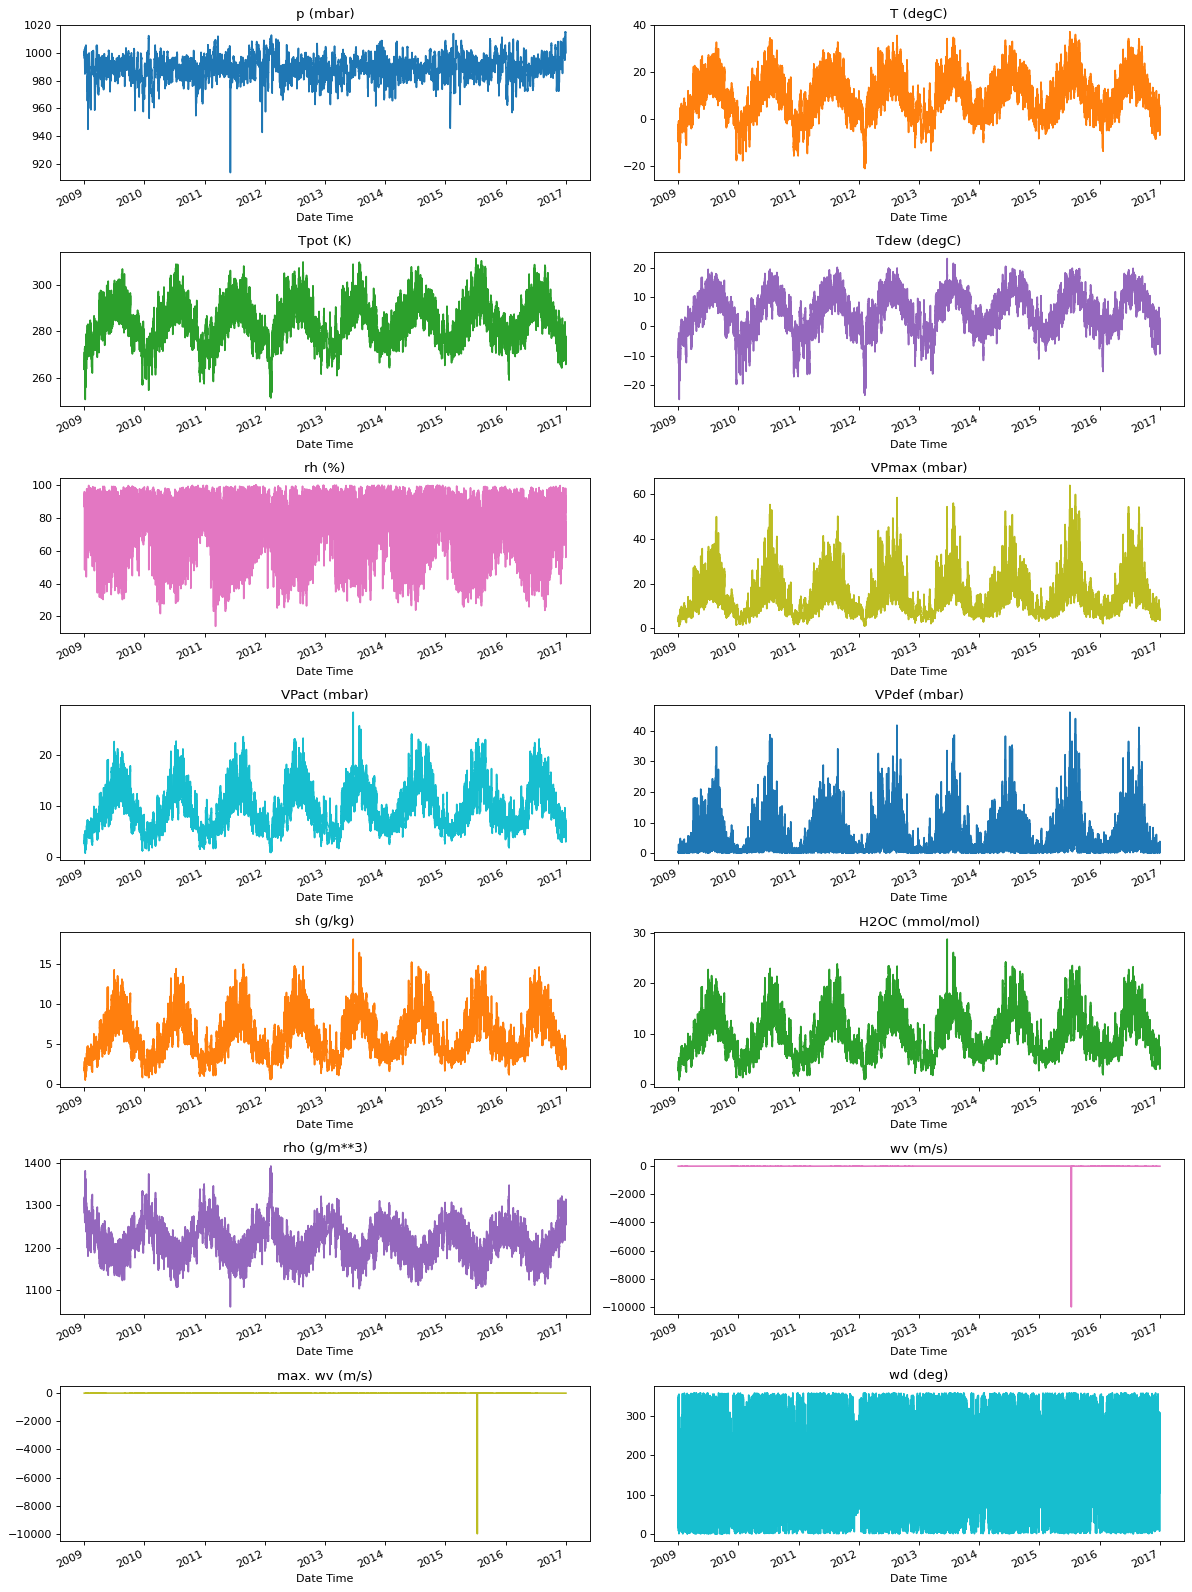

In [68]:
def show_raw_visualization(data):
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:pink', 'tab:olive', 'tab:cyan']
    fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k")
    for i, col in enumerate(list(data.columns)):
        ax = data[col].plot(
            ax=axes[i // 2, i % 2],title=col,rot=25, color=colors[i%len(colors)])
    plt.tight_layout()

show_raw_visualization(df)

In [ ]:
## clean outliers from wind speed

display(df.filter(regex='wv').describe())

display(df.filter(regex='wv').sort_values(by='wv (m/s)').head(5))

df['wv (m/s)']  = df['wv (m/s)'].replace(-9999.0, 0).values
df['max. wv (m/s)']  = df['max. wv (m/s)'].replace(-9999.0, 0).values

## create wind vector columns instead of direction and velocity
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

In [69]:
## To give model knowledge of seasonality:
import datetime
import numpy as np

## timestamp in seconds
timestamp_s = df.reset_index()['Date Time'].map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day)).values
df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day)).values
df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year)).values
df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year)).values

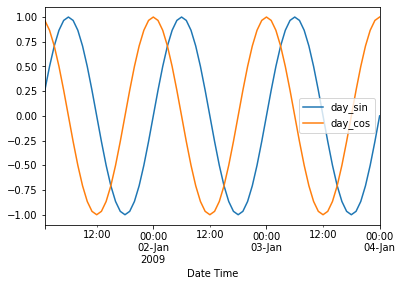

In [70]:
df.filter(regex='day_').head(72).plot()

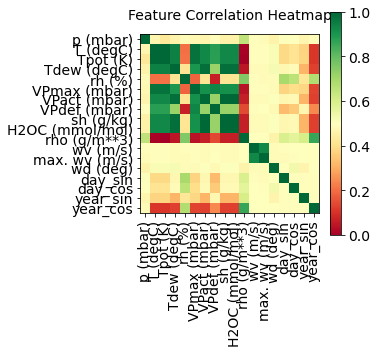

In [71]:
def show_heatmap(data):
    import matplotlib as mp
    plt.matshow(data.corr(), cmap='RdYlGn')
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar(mp.cm.ScalarMappable(cmap='RdYlGn'))
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()

show_heatmap(df)

In [ ]:
df.head()

# Data Processing

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

## we are using 70% for training, 20% for validation, and 10% for test
train_amt=0.7
val_amt=0.2
n = len(df)
train_df = df[0:int(n*train_amt)]
val_df = df[int(n*train_amt):int(n*(train_amt + val_amt))]
test_df = df[int(n*train_amt+val_amt):]

num_features = df.shape[1]

In [ ]:
## we use just train mean and train std instead of rolling normalization
## we normalize data to take out means and variances
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
display(train_df.describe().round(2))

display(train_df.kurtosis().to_frame().round(2).T)

In [ ]:
def gen_train_val_test(df, train_amt, val_amt):
  column_indices = {name: i for i, name in enumerate(df.columns)}
  n = len(df)
  train_df = df[0:int(n*train_amt)]
  val_df = df[int(n*train_amt):int(n*(train_amt + val_amt))]
  test_df = df[int(n*train_amt+val_amt):]

  train_mean = train_df.mean()
  train_std = train_df.std()

  train_df = (train_df - train_mean) / train_std
  val_df = (val_df - train_mean) / train_std
  test_df = (test_df - train_mean) / train_std
  
  return train_df, val_df, test_df

# Data Windowing

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, batch_size,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
    self.batch_size = batch_size

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=self.batch_size)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def validation(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

In [72]:
def gen_windows(train_df, val_df, test_df, verbose=False, batch_size=32):
  ## using past 24 hours to predict next hour
  ts_window = WindowGenerator(input_width=24, label_width=1, shift=1,batch_size=batch_size, 
                              train_df=train_df, val_df=val_df, test_df=test_df,
                              label_columns=['T (degC)'])

  print(ts_window)

  if verbose:
    for example_inputs, example_labels in ts_window.train.take(1):
      print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
      print(f'Labels shape (batch, time, features): {example_labels.shape}')

  ## using past 24 hours to predict 24 hours later
  tsshift_window = WindowGenerator(input_width=24, label_width=1, shift=24,batch_size=batch_size, 
                                   train_df=train_df, val_df=val_df, test_df=test_df,
                                    label_columns=['T (degC)'])

  print(tsshift_window)

  if verbose:
    for example_inputs, example_labels in tsshift_window.train.take(1):
      print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
      print(f'Labels shape (batch, time, features): {example_labels.shape}')

  ## using past 24 hours to predict 24 hours later
  tsblock_window = WindowGenerator(input_width=24, label_width=24, shift=24,batch_size=batch_size, 
                                   train_df=train_df, val_df=val_df, test_df=test_df,
                                  label_columns=['T (degC)'])

  print(tsblock_window)

  if verbose:
    for example_inputs, example_labels in tsblock_window.train.take(1):
      print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
      print(f'Labels shape (batch, time, features): {example_labels.shape}')

  return (ts_window, tsshift_window, tsblock_window)

In [73]:
train_df, val_df, test_df = gen_train_val_test(df, 0.7, 0.2)
ts_window, tsshift_window, tsblock_window = gen_windows(train_df, val_df, test_df)

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['T (degC)']
Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']
Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['T (degC)']


# Training

In [ ]:
import pickle
import pandas as pd
from time import time
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time() - self.epoch_time_start)

def compile_and_fit(model, window, checkpoint_name,
                    epochs=10, learning_rate = 0.001, verbose=1
                    ):

  early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

  checkpoint = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=checkpoint_name,
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
  )

  timingcb = TimeHistory()

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")

  history = model.fit(
      window.train,
      epochs=epochs,
      validation_data=window.validation,
      callbacks=[early_stopping, checkpoint, timingcb],
      verbose=verbose
  )

  pd.DataFrame(timingcb.times).to_csv(checkpoint_name.replace(".h5", "_timingcb.csv"))

  model.save(checkpoint_name)

  history.history['test_eval'] = model.evaluate(window.test)
  pickle.dump(history.history, open(checkpoint_name.replace(".h5", ".pickle"), 'wb'))

  return(history)

In [ ]:
## input ignores batch size
def lstm_model(lstm_size, input_shape):
  inputs = keras.layers.Input(shape=input_shape)
  lstm_out = keras.layers.LSTM(lstm_size)(inputs)
  outputs = keras.layers.Dense(1)(lstm_out)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return(model)

In [ ]:
def sequential_model(num_layers, l2, dropout, input_shape):
  layers_list = [keras.layers.Flatten(input_shape=input_shape)]
  for layer in range(0, num_layers):
    if l2:
      layers_list.append(keras.layers.Dense(32, activation='relu', 
        kernel_regularizer=keras.regularizers.l2(1e-4)))
    else:
      layers_list.append(keras.layers.Dense(32, activation='relu'))
    if dropout:
      layers_list.append(keras.layers.Dropout(rate=0.2))
    layers_list.append(keras.layers.BatchNormalization(),)
    
  layers_list.append(keras.layers.Dense(1))
  model = keras.models.Sequential(layers_list)
  model.build()

  return(model)

## Sequential Model Experiments

In [ ]:
batch_size=128
train_df, val_df, test_df = gen_train_val_test(df, 0.7, 0.2)
ts_window, tsshift_window, tsblock_window = gen_windows(train_df, val_df, test_df, batch_size=batch_size)

windows_dict = {
                'tsshift': tsshift_window,
                'tsblock': tsblock_window,
                'ts': ts_window,
                }

for window_name, window in windows_dict.items():
  for layers in [1, 2, 3, 4, 5]:
    for l2 in [True, False]:
      for dropout in [True, False]:
        filename = f'{root_path}/model.seq_window.{window_name}_batchsize.{batch_size}_layers.{layers}_l2.{l2}_dropout.{dropout}.h5'
        if os.path.exists(filename):
          print("%s exists"%filename)
          #continue
        model = sequential_model(2, l2=True, dropout=True, input_shape=window.example[0].shape[1:])
        #print('Input shape:', window.example[0].shape)
        #print('Output shape:', model(window.example[0]).shape)
        history = compile_and_fit(model, window, f'{root_path}/model.seq_window.{window_name}_batchsize.{batch_size}_layers.{layers}_l2.{l2}_dropout.{dropout}.h5', epochs=100)

## Sequential Model Experiments with Feature Selection

In [ ]:
input = []
output = []
for batch in ts_window.train.take(20000):
  x,y = batch
  input.extend(np.asarray([y[0] for y in x.numpy()]))
  output.extend([x[0][0] for x in y.numpy()])
input = np.asarray(input)
output = np.asarray(output)

In [ ]:
import statsmodels.api as sm
linear = sm.OLS(output, input).fit_regularized(alpha=0.2, L1_wt=0.5)
pd.DataFrame(linear.params, index = train_df.columns, columns = ['coef']).T.round(2)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,day_sin,day_cos,year_sin,year_cos
coef,0.0,0.29,0.23,0.07,0.0,0.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.13


In [ ]:
batch_size=32
train_df, val_df, test_df = gen_train_val_test(df[['T (degC)', 'Tpot (K)', 'Tdew (degC)', 'VPmax (mbar)', 'year_cos']], 0.7, 0.2)
ts_window, tsshift_window, tsblock_window = gen_windows(train_df, val_df, test_df, batch_size=batch_size)

windows_dict = {
                'tsshift': tsshift_window,
                'tsblock': tsblock_window,
                'ts': ts_window,
                }

for window_name, window in windows_dict.items():
  for layers in [1, 2, 3, 4, 5]:
    for l2 in [True, False]:
      for dropout in [True, False]:
        filename = f'{root_path}/model.seq_window.{window_name}_batchsize.{batch_size}_layers.{layers}_l2.{l2}_dropout.{dropout}.h5'
        if os.path.exists(filename):
          print("%s exists"%filename)
          continue
        model = sequential_model(2, l2=True, dropout=True, input_shape=window.example[0].shape[1:])
        #print('Input shape:', window.example[0].shape)
        #print('Output shape:', model(window.example[0]).shape)
        history = compile_and_fit(model, window, f'{root_path}/model.seqfeatureselected_window.{window_name}_batchsize.{batch_size}_layers.{layers}_l2.{l2}_dropout.{dropout}.h5', epochs=100)

## LSTM Model Experiments

In [ ]:
batch_size=128
train_df, val_df, test_df = gen_train_val_test(df, 0.7, 0.2)
ts_window, tsshift_window, tsblock_window = gen_windows(train_df, val_df, test_df, batch_size=batch_size)


windows_dict = {
                'tsshift': tsshift_window,
                'tsblock': tsblock_window,
                'ts': ts_window,
                }

for window_name, window in windows_dict.items():
  for lstm_size in range(3, 10):
        lstm_size = 2**lstm_size

        filename = f'{root_path}/model.lstm_window.{window_name}_batchsize.{batch_size}_lstmsize.{lstm_size}.h5'
        if os.path.exists(filename):
          print("%s exists"%filename)
          continue
        model = lstm_model(lstm_size, input_shape=window.example[0].shape[1:])
        #print('Input shape:', window.example[0].shape)
        #print('Output shape:', model(window.example[0]).shape)
        history = compile_and_fit(model, window, filename, epochs=100, verbose=2)

## Test Post Analysis

In [80]:
filename = '/content/drive/MyDrive/Colab Notebooks/final_project/model.seq_window.ts_batchsize.32_layers.3_l2.True_dropout.False.h5'

import pickle
history = pickle.load(open(filename.replace(".h5", ".pickle"), 'rb'))
history['test_eval']

0.02166682481765747

In [81]:
batch_size=32
train_df, val_df, test_df = gen_train_val_test(df, 0.7, 0.2)
ts_window, tsshift_window, tsblock_window = gen_windows(train_df, val_df, test_df, batch_size=batch_size)

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['T (degC)']
Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']
Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['T (degC)']


In [82]:
model = keras.models.load_model(filename)
predictions = model.predict(ts_window.test)

In [78]:
for x,y in tsshift_window.test.take(1):
  print(x.shape)
  print(y.shape)

(32, 24, 18)
(32, 1, 1)


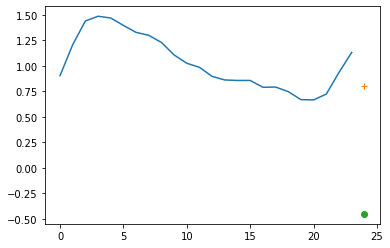

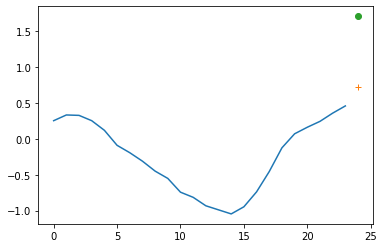

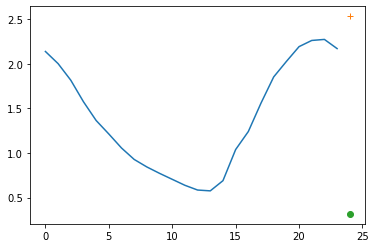

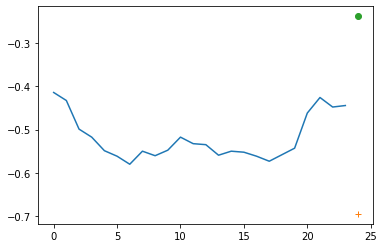

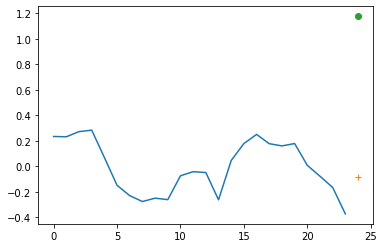

In [79]:
for i in range(2,7):
  plt.plot(x[i].numpy().T[1])
  plt.plot(24, y[i], marker='+')
  plt.plot(24, predictions[i], marker='o')
  plt.show()

# Post-Experiment Analysis

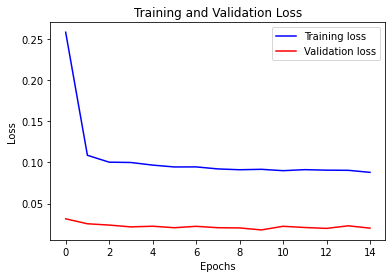

In [84]:
def visualize_loss(history, title):
    loss = history["loss"]
    val_loss = history["val_loss"]
    epochs = range(len(val_loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")